# Using OCRs in Python: Tesseract and Vision

This notebook is part of the Danilo J. S. Bellini's talk to the SciPy-SP community meeting that happened on March 14, 2018, at the *Eretz.bio* - Albert Einstein Hospital - São Paulo - Brazil.

Previously, [a very simple OCR for handwritten digits](https://github.com/danilobellini/notebooks/blob/master/2017-11-13_OCR_GruPy-SP_10_anos.ipynb) was presented as part of the GruPy-SP, written from scratch in 9 minutes. However, a more general solution should not just receive isolated characters, but a full image that has general text spread everywhere. That's hard to find a dataset to train such an OCR, and a more advanced OCR system should be concerned with:

- Finding if there's any text on the image
- Finding where are the text blocks on the image
- Finding the size and position in pixels for each character or multichar glyph in a text block
- Dealing with distinct fonts
- Filtering out any extra information from the image (noise, lighting, non-text)
- Dealing with uncertainty (e.g. distinguishing the lowercase "L" from the number "one", partial occlusion, etc.)
- Giving context/structural information to the found characters/words/text

Building such a system from scratch is difficult and would require way more time to be built. It's about finding structure in several levels (blocks, sentences, words), something that even the scikit-learn package [wasn't written to deal with](http://scikit-learn.org/stable/faq.html#will-you-add-graphical-models-or-sequence-prediction-to-scikit-learn). How should a dataset be assorted for training such a system? Luckily, there are available solutions.

The goal of this work is to show [Tesseract](https://github.com/tesseract-ocr/tesseract), its interface as a general *Optical Character Recognition* (OCR) solution, and a way to use it from a Python module. At the end, there's a short comparison with the Google Vision's text annotation detection service.

Softwares used to create this Notebook: `tesseract`, `docker`, `python` (3.6) and `Linux`. Python packages installed: `pillow` (PIL fork), `pytesseract`, `numpy`, `matplotlib`, `pandas`, `bs4` (BeautifulSoup), `google-cloud-vision`.

## Part 1: Creating a CAPTCHA dataset with pillow

Our first goal is to create a simple OCR task where the solution quality can be somehow measured. A simple example would be a "CAPTCHA" dataset with a few hundreds of images, like this one created using the [pillow](https://pillow.readthedocs.io) package:

In [1]:
import random, string
from PIL import Image, ImageDraw, ImageFont

In [2]:
random.seed(11) # To run the whole notebook again without changes

In [3]:
charset = string.ascii_lowercase + string.digits
dejavu_ttf = "/usr/share/fonts/TTF/DejaVuSerif.ttf"

In [4]:
def make_captcha(n_chars=8, chars=charset, **kwargs):
    """A simple CAPTCHA generator written by Danilo J. S. Bellini."""
    text = "".join(random.choice(chars) for char_index in range(n_chars))
    return render_text_ellipses(text, **kwargs), text

In [5]:
def render_text_ellipses(text, width=340, height=80, n_ellipses=48,
                         ttf_font=dejavu_ttf, text_fill=.7):
    """CAPTCHA rendering function written by Danilo J. S. Bellini."""
    img = Image.new(mode="RGB", size=(width, height))
    draw = ImageDraw.Draw(img)

    # Background
    for ellipse_index in range(n_ellipses):
        ell_tl = (random.randrange(width), random.randrange(height))
        ell_br = (ell_tl[0] + random.randrange(width - ell_tl[0]),
                  ell_tl[1] + random.randrange(height - ell_tl[1]))
        draw.ellipse([ell_tl, ell_br],
                     fill=tuple(random.randrange(256) for c in range(3)))

    # Font
    trialw, trialh = ImageFont.truetype(ttf_font, height).getsize(text)
    font_size = int(min(height * width / trialw, trialh) * text_fill)
    font = ImageFont.truetype(ttf_font, font_size)

    # Write the text
    writtenw, writtenh = font.getsize(text)
    text_top_left = (width - writtenw) / 2, (height - writtenh) / 2
    draw.text(text_top_left, text, font=font, anchor="center")
    return img

The dataset itself, as `(PIL image, solution)` pairs:

In [6]:
%%time
captchas = [make_captcha() for catpcha_index in range(500)]

CPU times: user 1.15 s, sys: 28 ms, total: 1.18 s
Wall time: 1.18 s


The first CAPTCHAs generated are:

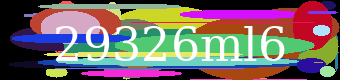

In [7]:
captchas[0][0]

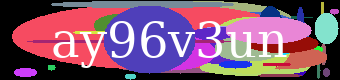

In [8]:
captchas[1][0]

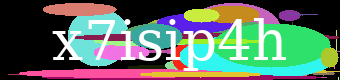

In [9]:
captchas[2][0]

Actually, CAPTCHA stands for *Completely Automated Public Turing test to tell Computers and Humans Apart*, and the task of an OCR solution here is to make these images fail as CAPTCHAs: the test won't be able to tell computers and humans apart if an OCR can read the text embedded in the images.

Goal: make an OCR that solves that CAPTCHA!

## Part 2: Getting started with the Tesseract CLI

[Tesseract](https://github.com/tesseract-ocr/tesseract) has a command-line interface to the OCR. The version used to make this notebook is 3.05.01:

In [10]:
!tesseract --version

tesseract 3.05.01
 leptonica-1.75.3
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.5.3) : libpng 1.6.34 : libtiff 4.0.9 : zlib 1.2.11 : libwebp 0.6.1



In [11]:
!tesseract --help

Usage:
  tesseract --help | --help-psm | --help-oem | --version
  tesseract --list-langs [--tessdata-dir PATH]
  tesseract --print-parameters [options...] [configfile...]
  tesseract imagename|stdin outputbase|stdout [options...] [configfile...]

OCR options:
  --tessdata-dir PATH   Specify the location of tessdata path.
  --user-words PATH     Specify the location of user words file.
  --user-patterns PATH  Specify the location of user patterns file.
  -l LANG[+LANG]        Specify language(s) used for OCR.
  -c VAR=VALUE          Set value for config variables.
                        Multiple -c arguments are allowed.
  --psm NUM             Specify page segmentation mode.
  --oem NUM             Specify OCR Engine mode.
NOTE: These options must occur before any configfile.

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segme

### Repeated single-character example

Let's use this to solve a simpler image. Say we've got a simple "HHHHH" message:

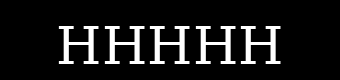

In [12]:
fiveh = render_text_ellipses("HHHHH", n_ellipses=0).convert("L")
fiveh

In order to use Tesseract, we have to write this to disk.

In [13]:
fiveh.save("fiveh.png")

A call to Tesseract can be done with `tesseract input_filename output_filename`, where the standard streams are represented by the `-` symbol instead of a file name.

In [14]:
!tesseract fiveh.png -

Warning. Invalid resolution 0 dpi. Using 70 instead.
HHHHH



And it works! We can get rid from the warning by using `dpi=(70, 70)` when saving the PNG image (for more information, see the [pillow parameters for each supported format](https://pillow.readthedocs.io/en/latest/handbook/image-file-formats.html)), as Tesseract gets that "invalid" zero from the image metadata.

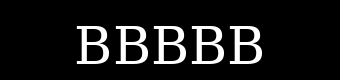

In [15]:
fiveb = render_text_ellipses("BBBBB", n_ellipses=0).convert("L")
fiveb

In [16]:
fiveb.save("fiveb.png", dpi=(70, 70))

In [17]:
!tesseract fiveb.png -

BBBBB



As a final remark about this simple command line, Tesseract also has a nonstandard file name gotcha: the names `stdin` and `stdout` can be used instead of `-`.

### Bringing a CAPTCHA to Tesseract

Let's try to solve this CAPTCHA from the generated dataset:

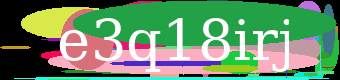

In [18]:
c15 = captchas[15][0]
c15

In [19]:
c15.save("c15.png", dpi=(70, 70))

In [20]:
!tesseract c15.png -

Empty page!!
Empty page!!


It got... nothing! The "Empty page!!" that appeared twice was actually a message sent to the error stream, not to the output stream.

In [21]:
!tesseract c15.png - 2> /dev/null

This CAPTCHA image might look difficult at first, but when we get just the "pure white" region of that image, we're able to get rid from those noisy ellipses. Getting rid from the noise/background is usually a required step when dealing with OCR.

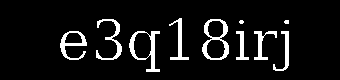

In [22]:
c15w = c15.convert("L").point(lambda x: 255 * (x == 255))
c15w

In [23]:
c15w.save("c15w.png", dpi=(70, 70))

In [24]:
!tesseract c15w.png -

€3q181rj



Almost there! As the charset that generates these CAPTCHA is restricted to lowercase ASCII characters and digits, we can tell Tesseract that's the case. To do so, we have to give to Tesseract a whitelist. Tesseract gets options with a `-c key=value` suffix in the command line, where the `key` should be `tessedit_char_whitelist` in this case:

In [25]:
!tesseract c15w.png - -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz0123456789

e3q18irj



And that was enough! Even the 6th char `i` got fixed!

To see the remaining options, run `tesseract --print-parameters`. For example, the options regarding while/black lists are:

In [26]:
!tesseract --print-parameters | grep 'char.*list'

tessedit_char_blacklist		Blacklist of chars not to recognize
tessedit_char_whitelist		Whitelist of chars to recognize
tessedit_char_unblacklist		List of chars to override tessedit_char_blacklist


### Calling with subprocess

Tesseract was being called from the notebook as cells with the `!` prefix, which spawns a subprocess calling the given command. However, in a Python source, you can't do that, and you probably will need the result in a Python variable, not just printed on the screen.

You can call Tesseract directly from your PIL image using two Python standard libraries:

- `subprocess`, to spawn a new process given a command line;
- `tempfile`, to create a temporary file.

In [27]:
import subprocess, tempfile

def tesseract_ocr(img, extra=(), **options):
    with tempfile.NamedTemporaryFile(suffix=".png") as tmp:
        img.save(tmp, dpi=(70, 70))
        command = ["tesseract", tmp.name, "-"]
        for key, value in options.items():
            command.extend(["-c", f"{key}={value}"])
        command.extend(extra)
        proc = subprocess.Popen(command, stdout=subprocess.PIPE)
        return proc.communicate()[0].strip().decode("utf-8")

In [28]:
tesseract_ocr(c15w, tessedit_char_whitelist=charset)

'e3q18irj'

This way, Tesseract is already useful directly from Python, and you don't need to care about files. Now we're able to evaluate the result in the whole CAPTCHA dataset:

In [29]:
def solve_captcha(img):
    return tesseract_ocr(img.convert("L")
                            .point(lambda x: 255 * (x == 255)),
                         tessedit_char_whitelist=charset)

In [30]:
%%time
captchas_imgs, captchas_solutions = map(list, zip(*captchas))
captchas_results = list(map(solve_captcha, captchas_imgs))

CPU times: user 484 ms, sys: 855 ms, total: 1.34 s
Wall time: 58.9 s


Though this isn't a machine learning training process, there are many possible metrics here (e.g. number of single-char replacements, number of 8-character results), but for now the overall accuracy is probably what matters the most.

In [31]:
import pandas as pd

In [32]:
dframe = pd.DataFrame([captchas_results, captchas_solutions],
                      index=["result", "expected"]).T
accuracy = (dframe["result"] == dframe["expected"]).mean()
accuracy

0.51

That accuracy value isn't bad, but that's still slow. One could crop the image border and resize it to send a smaller image to the OCR, as long as that keeps [at least 20 pixels](https://github.com/tesseract-ocr/tesseract/wiki/FAQ#is-there-a-minimum-text-size-it-wont-read-screen-text) for the lowercase `x` height.

But, for now let's forget about optimization issues, and let's see what's going on with these 49% CAPTCHAs that this simple OCR system wasn't able to get right:

In [33]:
dframe[dframe.result != dframe.expected].head(15)

,result,expected
0,29326n 6,29326ml6
1,ay9 6v3 1111,ay96v3un
4,dtlcu7q5,dt1cu7q5
5,01a4irr0,ola4irr0
7,qeqypnle,qeqypn1e
10,1258siky,1zs8siky
11,v 9g6,vfl9g6fl
16,cg100e31,cg1o0e3l
21,41pnlzr2,4lpnlzr2
22,7114cirhk,7n4cirhk


Most errors seem to be a replacement in similar sets of glyphs like `oO` (*oh* and *zero*), `1li` (*one*, *lower L* and *lower I*) and `s5`. However, situations like `17wizmvc` and `5xkoy4j5` are fine, they just have an extra whitespace, which can be removed. A better solver to the proposed CAPTCHA generator should enforce that the result don't have whitespaces, i.e., it's a single "word":

In [34]:
spaceless_result = dframe["result"].apply(lambda r: "".join(r.split()))
(spaceless_result == dframe["expected"]).mean()

0.57

That's a 6% improvement. On images like this one, the joined chars troubled our OCR:

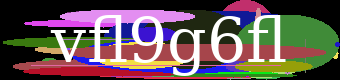

In [35]:
captchas_imgs[11]

We probably can get a better result with more image processing steps before sending the image to Tesseract, for example something that can break the `fl` apart in the example above, but, for now, let's move on: solving CAPTCHAs by calling Tesseract with subprocess isn't the only task and OCR solution we can thing of.

## Part 3: Single char boxes layout and pytesseract

One can keep on using the Tesseract directly with system calls, but there's a package in PyPI that makes Tesseract really simple to be used from Python, [pytesseract](https://pypi.python.org/pypi/pytesseract):

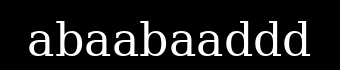

In [36]:
abcd_img = render_text_ellipses("abaabaaddd", width=340, height=70,
                                n_ellipses=0, text_fill=.85).convert("L")
abcd_img

In [37]:
import pytesseract

In [38]:
pytesseract.image_to_string(abcd_img)

'abaabaaddd'

The `pytesseract.image_to_string` is somewhat similar to the formerly defined `tesseract_ocr` function (it also saves the image into a temporary file and performs a system call), but we pass the Tesseract command line options as a single string in the `config` keyword argument, e.g. let's try to read `OSlZBGI` using two whitelists:

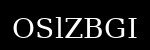

In [39]:
oslz_img = render_text_ellipses("OSlZBGI", width=150, height=50,
                                n_ellipses=0, text_fill=.85).convert("L")
oslz_img

In [40]:
pytesseract.image_to_string(oslz_img,
    config="-c tessedit_char_whitelist=" + string.ascii_uppercase)

'OSIZBGI'

In [41]:
pytesseract.image_to_string(oslz_img,
    config="-c tessedit_char_whitelist=" + string.digits)

'08121361'

The `B` interpreted as `13` might have been unexpected, but it somehow makes sense. Tesseract works with both monospaced fonts and more compact fonts. But, if we wanted to get rid from that leading `1`, how could we know the `13` comes from the same written character?

### Boxes output

There's an alternative Tesseract output that includes the bounding box information for each character that was found. To get that output, just call Tesseract with the `tessedit_create_boxfile=1` option:

In [42]:
oslz_img.save("oslz.png", dpi=(70, 70))

In [43]:
!tesseract oslz.png - -c tessedit_create_boxfile=1

O 14 12 33 32 0
S 37 12 52 32 0
I 56 12 63 33 0
Z 65 12 82 32 0
B 85 12 102 32 0
G 106 12 124 32 0
I 129 12 137 32 0


That result is a `char left bottom right top page` table, with the origin at the bottom left corner. One can get a similar result from pytesseract with the `image_to_boxes` function (it also sets `-c chop_enable=0 -c wordrec_enable_assoc=0`, which doesn't matter in this example):

In [44]:
pytesseract.image_to_boxes(oslz_img)

'O 14 12 33 32 0\nS 37 12 52 32 0\nI 56 12 63 33 0\nZ 65 12 82 32 0\nB 85 12 102 32 0\nG 106 12 124 32 0\nI 129 12 137 32 0'

That function can also parse its output into a dictionary:

In [45]:
pytesseract.image_to_boxes(oslz_img, output_type="dict")

{'bottom': [12, 12, 12, 12, 12, 12, 12],
 'char': ['O', 'S', 'I', 'Z', 'B', 'G', 'I'],
 'left': [14, 37, 56, 65, 85, 106, 129],
 'page': [0, 0, 0, 0, 0, 0, 0],
 'right': [33, 52, 63, 82, 102, 124, 137],
 'top': [32, 32, 33, 32, 32, 32, 32]}

Unless one is just trying to find some extrema, it's perhaps easier to deal with the raw string:

In [46]:
oslz_bpairs = [(char, list(map(int, coords)))
               for row in pytesseract.image_to_boxes(oslz_img).splitlines()
               for char, *coords in [row.split()[:-1]]]
oslz_bpairs

[('O', [14, 12, 33, 32]),
 ('S', [37, 12, 52, 32]),
 ('I', [56, 12, 63, 33]),
 ('Z', [65, 12, 82, 32]),
 ('B', [85, 12, 102, 32]),
 ('G', [106, 12, 124, 32]),
 ('I', [129, 12, 137, 32])]

The bottom-left corner isn't default origin in most image processing packages, these usually use the top-left corner as the origin.

In [47]:
oslz_bboxes = [(left, oslz_img.height - bottom,
                right, oslz_img.height - top)
               for char, (left, bottom, right, top) in oslz_bpairs]
oslz_bboxes

[(14, 38, 33, 18),
 (37, 38, 52, 18),
 (56, 38, 63, 17),
 (65, 38, 82, 18),
 (85, 38, 102, 18),
 (106, 38, 124, 18),
 (129, 38, 137, 18)]

Let's see these bounding boxes in the original image.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

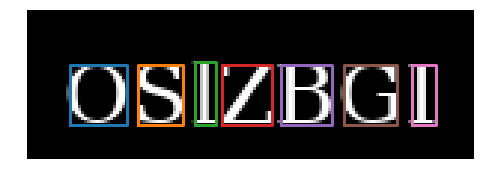

In [49]:
plt.figure(figsize=(8, 3))
plt.imshow(np.array(oslz_img), cmap=plt.cm.gray)
for x0, y0, x1, y1 in oslz_bboxes:
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], lw=3)
plt.axis("off");

### The disabled chop/associate gotcha in pytesseract

One can see in the Tesseract result forcing the interpretation as digits that the two `13` digits that represents the `B` are the only ones with an overlap (the `[left, right]` coordinates are `[85, 92]` and `[89, 102]`):

In [50]:
!tesseract oslz.png - \
  -c tessedit_create_boxfile=1 \
  -c tessedit_char_whitelist=0123456789

0 14 12 33 32 0
8 37 12 52 32 0
1 56 12 63 33 0
2 65 12 82 32 0
1 85 12 92 32 0
3 89 12 102 32 0
6 106 12 124 32 0
1 129 12 137 32 0


Actually, with `chop_enable=0`, and still forcing a digits interpretation, the `B` is interpreted as `3`, it no longer have the leading/overlapping `1`:

In [51]:
!tesseract oslz.png - \
  -c chop_enable=0 \
  -c tessedit_create_boxfile=1 \
  -c tessedit_char_whitelist=0123456789

0 14 12 33 32 0
8 37 12 52 32 0
1 56 12 63 33 0
2 65 12 82 32 0
3 85 12 102 32 0
6 106 12 124 32 0
1 129 12 137 32 0


It might be hard to tweak with the Tesseract configuration, but that's what explain the following pytesseract gotcha:

In [52]:
print("String:", # B is 13
      pytesseract.image_to_string(oslz_img,
          config="-c tessedit_char_whitelist=" + string.digits), sep="\n")
print("Boxes:", # B is 3, though the parameters seem to be the same
      pytesseract.image_to_boxes(oslz_img,
          config="-c tessedit_char_whitelist=" + string.digits), sep="\n")

String:
08121361
Boxes:
0 14 12 33 32 0
8 37 12 52 32 0
1 56 12 63 33 0
2 65 12 82 32 0
3 85 12 102 32 0
6 106 12 124 32 0
1 129 12 137 32 0


To avoid that, set the `chop_enable=1` in the `image_to_boxes`:

In [53]:
oslzdig_string = pytesseract.image_to_boxes(oslz_img,
                     config="-c chop_enable=1 "
                            "-c tessedit_char_whitelist=" + string.digits)
print(oslzdig_string)

0 14 12 33 32 0
8 37 12 52 32 0
1 56 12 63 33 0
2 65 12 82 32 0
1 85 12 92 32 0
3 89 12 102 32 0
6 106 12 124 32 0
1 129 12 137 32 0


Trying to set `tessedit_create_boxfile=1` in the `image_to_string` won't make any difference:

In [54]:
pytesseract.image_to_string(oslz_img,
    config="-c tessedit_create_boxfile=1 "
           "-c tessedit_char_whitelist=" + string.digits)

'08121361'

The `tessedit_create_boxfile=1` was completely neglected. That's mostly about default values, but if you really want to take full control of Tesseract, you should use its CLI directly. Some Tesseract config files (e.g. `batch.nochop`, `makebox`, `txt`) are loaded by pytesseract, and unless you know what they are and when they are loaded, the resulting behavior might be surprising.

Finally, let's see the overlapping chars' bounding boxes:

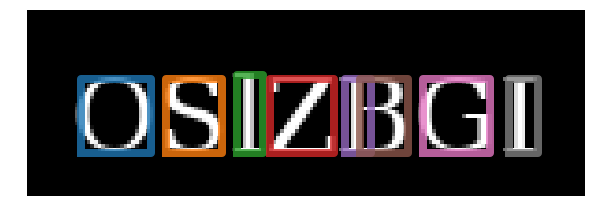

In [55]:
oslzdig_bpairs = [(char, list(map(int, coords)))
                  for row in oslzdig_string.splitlines()
                  for char, *coords in [row.split()[:-1]]]
oslzdig_bboxes = [(left, oslz_img.height - bottom,
                   right, oslz_img.height - top)
                  for char, (left, bottom, right, top) in oslzdig_bpairs]
plt.figure(figsize=(10, 4))
plt.imshow(np.array(oslz_img), cmap=plt.cm.gray)
for x0, y0, x1, y1 in oslzdig_bboxes:
    plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], lw=8, alpha=.8)
plt.axis("off");

When two chars are joined, chopping (`chop_enable`) is what seggregates them apart. The above image had `13` chopped from the single glyph/blob image. The opposite behavior is the association (`wordrec_enable_assoc`), which was also disabled by the `pytesseract.image_to_boxes` function, but doesn't make difference in this example because there's no "broken" character in that image.

## Part 4: Tesseract segmentation modes

Until now, we were using Tesseract for images with a single line of random characters that made no sense in any language. Suppose we're now trying to get the text information from this image, [this XKCD comic](https://xkcd.com/329/):

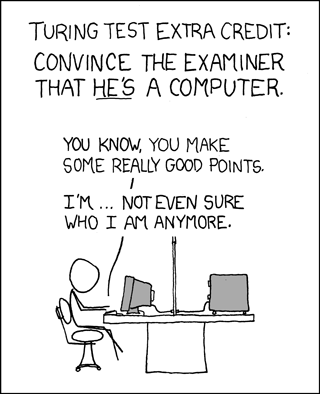

In [56]:
xkcd = Image.open("turing_test.png")
xkcd

By default, Tesseract tries to do a fully automatic page segmentation, so it works even for that image:

In [57]:
!tesseract turing_test.png -

 

 

TURING TEST EXTRA CREDlT:

CONVINCE THE EXAMINER
THAT FL'S A COMPUTER.

YOU KNOW. YOU MAKE
SOME REALLY GOOD POINTS
I

I'r’k“ NOTB/EN SURE
WHO I M ANYf’lORE.

/

 

 

 



The result has a lot of empty lines, and the lines with a single character are a interpretation to the curve that links the text to the examiner. We can get rid of a lot of that by just telling Tesseract that the image has a single uniform block of text, that is, the page segmentation mode is 6:

In [58]:
!tesseract turing_test.png - --psm 6

TURING TEST EXTRA CREDlT:
CONVINCE THE EXAMINER
THAT FL'S A COMPUTER.
YOU KNOW. YOU MAKE
SOME REfLLY GOOD Poms
I'r’k ., NOTB/EN SURE
WHO I M ANYf’lORE.



The same config can be passed to pytesseract. Let's do that, but enforcing a whitelist this time, as the message has nothing in lower case:

In [59]:
print(pytesseract.image_to_string(xkcd,
    config="--psm 6 "
           "-c tessedit_char_whitelist=\\'/:." + string.ascii_uppercase))

TURING TEST EXTRA CREDW:
CONVINCE THE EXAMINER
THAT FL'S A COMPUTER.
YOU KNOW. YOU MAKE
SOME RE:ALLY GOOD POINTS
IN .V NOTB/EN SURE
WHO I M ANYHORE.


### Rotation

What are the possible parameters to the `--psm` option?

In [60]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR.
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
			bypassing hacks that are Tesseract-specific.


In this Tesseract version, there are 14 page segmentation modes. The default is `--psm 3`, and has no OSD, like most options. But, what's OSD all about anyway?

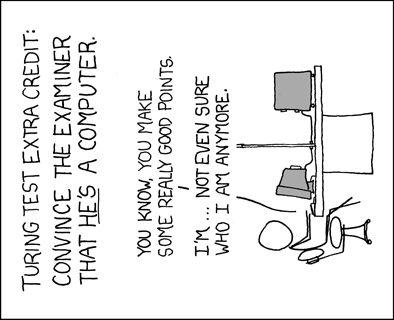

In [61]:
xkcd.rotate(90, expand=True)

That rotated image might be an OCR input. Tesseract might find the text orientation in the "zeroth" page segmentation mode (this specific PSM value doesn't work with `pytesseract.image_to_string`):

In [62]:
print(tesseract_ocr(xkcd.rotate(90, expand=True), extra=["--psm", "0"]))

Page number: 0
Orientation in degrees: 270
Rotate: 90
Orientation confidence: 5.50
Script: Latin
Script confidence: 108.33


In [63]:
print(tesseract_ocr(xkcd.rotate(180, expand=True), extra=["--psm", "0"]))

Page number: 0
Orientation in degrees: 180
Rotate: 180
Orientation confidence: 6.45
Script: Latin
Script confidence: 85.56


In [64]:
print(tesseract_ocr(xkcd.rotate(270, expand=True), extra=["--psm", "0"]))

Page number: 0
Orientation in degrees: 90
Rotate: 270
Orientation confidence: 5.12
Script: Latin
Script confidence: 220.00


Be careful with the "with OSD" page segmentation modes! You still have to rotate the image externally:

In [65]:
print(tesseract_ocr(xkcd.rotate(180, expand=True), extra=["--psm", "1"]))

/

'EEJOLJANV W I OHM
380$ NJ/GiON "NJ

I
‘SiNIOd (1000 WV}?! ENDS
31wi (10* MN)! (\OA

’HELOdNOJ V 5T4 mu
uamwx] 3H1 aonNoo

t_LVClEHJ VHDG .LSEL ONIHOJ.


### Raw line PSM

Now we can use the PSM 13 (raw line) to fix the previously joined `fl` chars of a CAPTCHA, effectively chopping them. This was the CAPTCHA:

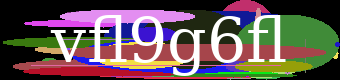

In [66]:
captchas_imgs[11]

Removing the background:

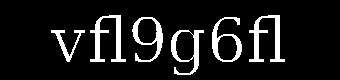

In [67]:
c11w = captchas_imgs[11].convert("L").point(lambda x: 255 * (x == 255))
c11w

In [68]:
print(pytesseract.image_to_string(c11w, config="--psm 13"))

Vﬂ9g6ﬂ


And this one works even for a way smaller image (but that's not always the case):

In [69]:
c11w_mini = c11w.copy()
c11w_mini.thumbnail((100, 100))
c11w_mini

In [70]:
print(pytesseract.image_to_string(c11w_mini, config="--psm 13"))

vﬂ9g6ﬂ


Using PSM 13, we can get an alternative solution to that CAPTCHA dataset. Let's do that, this time with some parallelism:

In [71]:
def solve_captcha_alt(img):
    bgless = img.convert("L").point(lambda x: 255 * (x == 255))
    config = f"--psm 13 -c tessedit_char_whitelist={charset}"
    result = pytesseract.image_to_string(bgless, config=config)
    return "".join(result.split())

In [72]:
from multiprocessing.dummy import Pool as ThreadPool

In [73]:
%%time
with ThreadPool(10) as pool:
    captchas_results_alt = pool.map(solve_captcha_alt, captchas_imgs)

CPU times: user 1.46 s, sys: 2.28 s, total: 3.74 s
Wall time: 27.9 s


In [74]:
dframe_alt = pd.DataFrame([captchas_results_alt, captchas_solutions],
                      index=["result", "expected"]).T
accuracy_alt = (dframe_alt["result"] == dframe_alt["expected"]).mean()
accuracy_alt

0.542

For the whole thing, it's not better than the previous result, and with the 100x100 thumbnailing the result would be much worser (less than 15% for no real speed gain). Tweaking some parameters, [like these suggestions for Japanese/Chinese](https://github.com/tesseract-ocr/tesseract/wiki/ControlParams) from [here](https://groups.google.com/d/msg/tesseract-ocr/A4IQlslY7hc/d4xK1PoihfMJ) will really help us to go beyond that 57% accuracy, but, for Tesseract, the previous/external image manipulation is essential. Remember: with the ellipses background in the images, Tesseract didn't find anything.

## Part 5: Other stuff regarding Tesseract

### The hOCR output format

The boxfile format (table with a bounding box for each character) and the text output aren't the only Tesseract output values:

In [75]:
!tesseract --print-parameters | grep tessedit_create_

tessedit_create_txt	0	Write .txt output file
tessedit_create_hocr	0	Write .html hOCR output file
tessedit_create_tsv	0	Write .tsv output file
tessedit_create_pdf	0	Write .pdf output file
tessedit_create_boxfile	0	Output text with boxes


To choose between these results, you just need to set one of them to true (the value 1). For example, the [hOCR](ieeexplore.ieee.org/document/4377078/) is a HTML format for OCR workflow and results.

In [76]:
hocr = tesseract_ocr(c11w,
                     extra=["--psm", "13"],
                     tessedit_create_hocr=1)
print(hocr)

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
 <head>
  <title></title>
<meta http-equiv="Content-Type" content="text/html;charset=utf-8" />
  <meta name='ocr-system' content='tesseract 3.05.01' />
  <meta name='ocr-capabilities' content='ocr_page ocr_carea ocr_par ocr_line ocrx_word'/>
</head>
<body>
  <div class='ocr_page' id='page_1' title='image "/tmp/tmp32k2tcgi.png"; bbox 0 0 340 80; ppageno 0'>
   <div class='ocr_carea' id='block_1_1' title="bbox 51 15 285 75">
    <p class='ocr_par' id='par_1_1' lang='eng' title="bbox 51 15 285 75">
     <span class='ocr_line' id='line_1_1' title="bbox 51 15 285 75; baseline -0 -13; x_size 60; x_descenders 13; x_ascenders 15"><span class='ocrx_word' id='word_1_1' title='bbox 51 15 285 75; x_wconf 87'>Vﬂ9g6ﬂ</span> 
     </span>
    </p>
   </div>
  </div>
 </bo

With BeautifulSoup, we can get the line text and the block bounding box, where both lines and words are "blocks", but not single characters:

In [77]:
import bs4

In [78]:
first = bs4.BeautifulSoup(hocr, "html5lib").select(".ocr_line")[0]
first.text.strip()

'Vﬂ9g6ﬂ'

In [79]:
first_title = first.attrs["title"]
first_title

'bbox 51 15 285 75; baseline -0 -13; x_size 60; x_descenders 13; x_ascenders 15'

This time, the bounding box is already in the top-left origin convention.

In [80]:
first_bbox = list(map(int, first_title.split(";")[0].split()[1:]))
first_bbox

[51, 15, 285, 75]

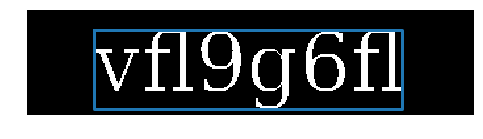

In [81]:
plt.figure(figsize=(8, 3))
plt.imshow(np.array(c11w), cmap=plt.cm.gray)
x0, y0, x1, y1 = first_bbox
plt.plot([x0, x0, x1, x1, x0], [y0, y1, y1, y0, y0], lw=3)
plt.axis("off");

### Tesseract configuration files

At the `tessdata` directory in your system (usually `/usr/share/tessdata/` or `/usr/local/share/tessdata/`), there are two configuration directories, `configs` and `tessconfigs`:

In [82]:
!ls /usr/share/tessdata/*configs/*

/usr/share/tessdata/configs/ambigs.train
/usr/share/tessdata/configs/api_config
/usr/share/tessdata/configs/bigram
/usr/share/tessdata/configs/box.train
/usr/share/tessdata/configs/box.train.stderr
/usr/share/tessdata/configs/digits
/usr/share/tessdata/configs/hocr
/usr/share/tessdata/configs/inter
/usr/share/tessdata/configs/kannada
/usr/share/tessdata/configs/linebox
/usr/share/tessdata/configs/logfile
/usr/share/tessdata/configs/makebox
/usr/share/tessdata/configs/pdf
/usr/share/tessdata/configs/quiet
/usr/share/tessdata/configs/rebox
/usr/share/tessdata/configs/strokewidth
/usr/share/tessdata/configs/tsv
/usr/share/tessdata/configs/txt
/usr/share/tessdata/configs/unlv
/usr/share/tessdata/tessconfigs/batch
/usr/share/tessdata/tessconfigs/batch.nochop
/usr/share/tessdata/tessconfigs/matdemo
/usr/share/tessdata/tessconfigs/msdemo
/usr/share/tessdata/tessconfigs/nobatch
/usr/share/tessdata/tessconfigs/segdemo


Each of these files is a default configuration you can use by appending its name (without the path) to the command line, e.g.:

In [83]:
!tesseract fiveb.png - makebox

B 77 16 109 54 0
B 116 16 148 54 0
B 154 16 186 54 0
B 192 16 224 54 0
B 230 16 262 54 0


The `makebox` config just sets what we already know:

In [84]:
!cat /usr/share/tessdata/configs/makebox

tessedit_create_boxfile 1


### Tesseract 4

As of today, Tesseract 4 isn't a stable version yet, it's migrating to a LSTM (Long short-term memory) neural network. We can try it from the [tesseractshadow/tesseract4re](https://hub.docker.com/r/tesseractshadow/tesseract4re/) Docker image:

In [85]:
!docker run --rm -it \
        tesseractshadow/tesseract4re \
        tesseract --version

tesseract 4.00.00alpha
 leptonica-1.74.1
  libgif 5.1.4 : libjpeg 8d (libjpeg-turbo 1.4.2) : libpng 1.2.54 : libtiff 4.0.6 : zlib 1.2.8 : libwebp 0.4.4 : libopenjp2 2.1.0

 Found AVX
 Found SSE


Let's evaluate the XKCD Turing test with both Tesseract 3 and Tesseract 4:

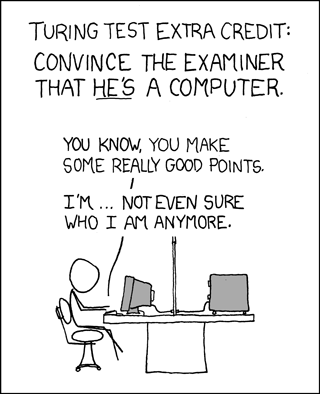

In [86]:
xkcd

In [87]:
!tesseract turing_test.png - --psm 6 \
            -c tessedit_char_whitelist=\'/:.ABCDEFGHIJKLMNOPQRSTUVWXYZ

TURING TEST EXTRA CREDW:
CONVINCE THE EXAMINER
THAT FL'S A COMPUTER.
YOU KNOW. YOU MAKE
SOME RE:ALLY GOOD POINTS
IN .V NOTB/EN SURE
WHO I M ANYHORE.



In [88]:
!docker run --rm -it -v "$PWD"/turing_test.png:/img.png \
        tesseractshadow/tesseract4re \
        tesseract /img.png - --psm 6 \
            -c tessedit_char_whitelist=\'/:.ABCDEFGHIJKLMNOPQRSTUVWXYZ

TURING TEST EXTRA CREDIT:
CONVINCE THE EXAMINER
THAT HES A COMPUTER
YOU KNOW, YOU MAKE
Sone RE:RLLY GoD PoinTS.
TM... NOTEVEN SURE
WHO T AM ANYMORE



Comparison:

- Tesseract 4 ignores the `tessedit_char_whitelist` configuration (and several other configurations, as well);
- The underscore (actually, any neighboring line) "distracts" Tesseract 3, it wasn't able to find the `HE'S`. On the other hand, Tesseract 4 got it right, it just ignored the `'` symbol;
- Tesseract 3 found the ending dot for `COMPUTER.` and `ANYMORE.`, but the dot after `POINT` and the `...` ellipsis weren't detected. Also, the comma was wrongly detected as a dot. Tesseract 4 did the opposite in these cases;
- The `REALLY` doesn't look difficult for humans, but both Tesseract versions weren't capable of finding it out as a single word (Tesseract 3 was pretty close). It's not clear why they detected a colon in the middle of that word;
- Some words are better in the Tesseract 4 result (`CREDIT`, `HES`, `NOTEVEN`, `AM ANYMORE`), others are better in the Tesseract 3 result (`SOME RE:ALLY GOOD`, `I`).

## Part 6: Google Vision as an alternative to Tesseract

For an image processing point of view, Google Vision might be easier to use than Tesseract, since it usually needs almost no image preprocessing to work. And for a single manual task using [its "Try the API" drag-n-drop web interface](https://cloud.google.com/vision/) instead of a programming language, it's free. Let's see an example trying to get the text of a receipt from a Brazilian restaurant:

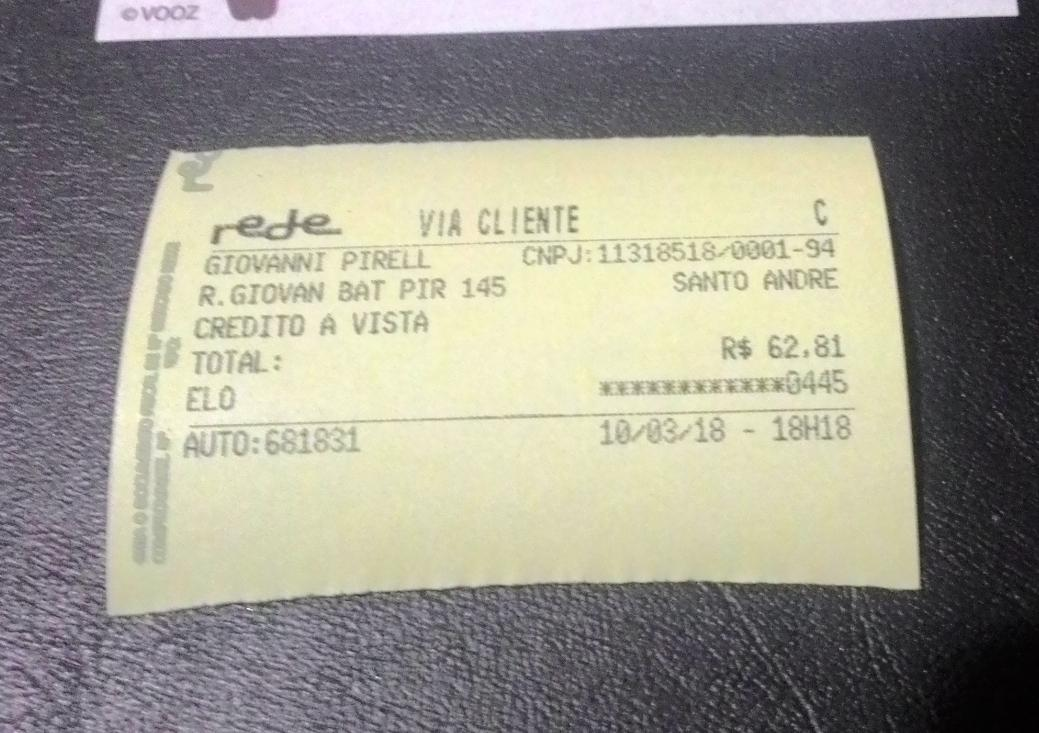

In [89]:
Image.open("receipt.jpg")

Tesseract 3 simply can't deal with this image directly, but Tesseract 4 gets some information (you can try other PSM/configuration):

In [90]:
!tesseract receipt.jpg - --psm 6

_~_\ rt'ﬁdﬂ . .‘. :‘1 : ~
‘1:~-"=-‘>’ ~ , . - ~ :1 . p1»;—
~":‘u ; , ‘ ,, ~ » : ~_: ‘ 2-.‘ g. $5.? ¥€
;\;;_‘~-¢3<: ‘ -‘
9317;53:13 {vi .1 5 ,.: ' . . ‘ ,.
:31? , __ , u 2.2:;
‘iﬁéﬁié‘: , “Hurutttj'q-E;
153:2???" ' ' - - 7 ;,f' ;
226$; , ﬂ ‘ . - ,7 > A. h
-E'i‘i
.i." i‘x"
wait
‘\I“ '>“"~‘ _\‘~' ‘
L» ‘4 ,, >~v u ‘ -- ‘I‘._‘> ,j ’- ‘ ,: ¥ \
A ~ , K r -_ \‘_‘~ \ ~ax;‘_‘_\;;\;,». .. ‘
‘ ‘ ‘55?) ‘kﬁjgiii’g‘ﬁns >5"? > '
R xx: 7 ‘ "\. u; ‘ 2: 41>.i§2’\;‘ ‘ 5}": -~: ' ’
r '. hwy :gxx'm vi-Eiazszg» 5.; _;; ,~ _ -. ~
'5; - v «@N A\~ ‘; 5:93;; 77-3.»..{3‘ :.-. _ .
.7». 7. Wﬁﬁx— “ ‘ﬁg‘sbx-m «
< ’ ’n— W‘;n\:§~¢;3\d~-QH ’ .’
, -&2‘1‘&“‘?w\”‘cﬁg r:~"»~ =\'\vf‘-’x' »‘ » ‘



In [91]:
!docker run --rm -it -v "$PWD"/receipt.jpg:/img.png \
        tesseractshadow/tesseract4re \
        tesseract /img.png - --psm 6

rede & CLI v
.> STOVAN R NP): i1318518-0001-44
ences" D CINUAN RAT p 145 SANTO ANDRE
aes R VE
ses - CREDITO A VIiSIF h
--- Ré 62.81
fig? r inescescncerc0445
_- g As -
s- AUTC ‘ 1 $10 - 10nic
aos
estes:
Sele
‘N‘i omor nts %
4 ket cesad tas Sit Wats CrO RTE h
be = He s ¢
f ssc ‘kssi‘rgsii’g‘f‘n; Ama Ns
= Co Moar S Fee tole rete Sonos : \
~. won ooo een non naaa f
Cx: vero 323)??? on oras #
=> o -
iF v -. mean times nme nea ine mac aio coo 1 l a &
f getline in elec a . o sive isl Pore rain 3s



Tesseract 4 found the `62.81` monetary value, some words/expressions like the `rede`, `SANTO ANDRE` and `CREDITO A`, and even the most part of the CNPJ number `11318518/0001-94` (the leading `1` was `i` and the slash was replaced by `-`). Such information could be extracted from the Tesseract 4 result using regexes, but we probably would prefer something more robust.

The Google Vision result was stored in the `gv_receipt.json` file, but part of it can be seen in [this image](gv_receipt.png):

![](gv_receipt.png)

It looks better: symbols like `R$` were detected, the ending `18H18` timestamp was detected, and a lot of more text! However, there are some mistakes in the middle of the numbers (e.g. `8` or `3` instead of `0`). As it seems, Google Vision ignores single-char blocks like the `C` in the upper right corner.

Let's understand better the JSON result from that "text annotations" API.

In [92]:
import json

In [93]:
with open("gv_receipt.json") as gvr_file:
    gvr = json.load(gvr_file)

In [94]:
gvr["textAnnotations"][0]

{'boundingPoly': {'vertices': [{'x': 159, 'y': 196},
   {'x': 845, 'y': 196},
   {'x': 845, 'y': 460},
   {'x': 159, 'y': 460}]},
 'description': 'reje. VIA CLIENTE\nGIOVANNI PIRELL CNPJ: 11318518-0801-94\nR. GIOVAN BAT PIR 145\nSANTO ANDRE\nCREDITO A VISTA\nT TOTAL:\nR$ 62.81\nELO\n***********3445\nAUTO:681831\n18/03/18 - 18H18\n',
 'locale': 'en'}

When calling from the API, we can set a language hint to avoid the `en` (English) locale, since the input receipt is written in Brazilian Portuguese. Nevertheless, this block is huge: The first item has all the text from the image joined together. Let's see some examples:

In [95]:
gvr["textAnnotations"][1]

{'boundingPoly': {'vertices': [{'x': 214, 'y': 203},
   {'x': 325, 'y': 201},
   {'x': 326, 'y': 242},
   {'x': 215, 'y': 244}]},
 'description': 'reje'}

In [96]:
gvr["textAnnotations"][26]

{'boundingPoly': {'vertices': [{'x': 188, 'y': 342},
   {'x': 259, 'y': 342},
   {'x': 259, 'y': 377},
   {'x': 188, 'y': 377}]},
 'description': 'TOTAL'}

In [97]:
gvr["textAnnotations"][27]

{'boundingPoly': {'vertices': [{'x': 270, 'y': 342},
   {'x': 279, 'y': 342},
   {'x': 279, 'y': 377},
   {'x': 270, 'y': 377}]},
 'description': ':'}

From these, we know the text blocks have two keys:

- `boundingPoly`: A polygon defined by four vertices;
- `description`: The block text, as a string.

Some information about these blocks:

- The bouding box isn't orthogonal, like the last `reje` example;
- The division is almost word-based. A block won't have pairs of words, but punctuation and other separators have their own blocks.

When using the [Google Vision API wrapper to Python](https://pypi.python.org/pypi/google-cloud-vision/0.30.1), these resources are nested in the same way, but represented as specific objects with attributes instead of nested dictionaries, but one should also care about having in the `GOOGLE_APPLICATION_CREDENTIALS` environment variable the file name of the JSON with the Google Cloud Platform credentials (yeah, it's not a free software, but a paid SaaS). An example for doing such is ([reference](https://google-cloud-python.readthedocs.io/en/latest/vision/index.html)):

```python
from io import BytesIO
from google.cloud import vision

def tobytes(pil_img):
    tmp = BytesIO()
    pil_img.save(tmp, format="PNG")
    tmp.flush()
    tmp.seek(0)
    return tmp.read()

def gv_ocr(pil_img):
    gv_client = vision.ImageAnnotatorClient()
    gv_img = vision.types.Image(content=tobytes(pil_img))
    return gv_client.text_detection(gv_img).text_annotations
```

The `gv_ocr` result is an iterable like the `gvr["textAnnotations"]` in the previously seen JSON example. The lowerCamelCase names like `textAnnotations` and `boundingPoly` that appears in the JSON are replaced by PEP8-friendly snake_case names like `text_annotations` and `bounding_poly` in that Python library.

## Next steps

For people interested in OCR and Tesseract, some hints:

- Use the language explicitly in Tesseract. By default, the option `-l eng` enables the English dictionary. For Brazilian Portuguese words, you should use `-l por`. The Tesseract Wiki in GitHub has [more information about data files](https://github.com/tesseract-ocr/tesseract/wiki/Data-Files);
- Look how to train both [Tesseract 3](https://github.com/tesseract-ocr/tesseract/wiki/Training-Tesseract-3.00%E2%80%933.02) and [Tesseract 4](https://github.com/tesseract-ocr/tesseract/wiki/TrainingTesseract-4.00);
- Look for other OCR tutorials, like [Javier Segovia's Breaking captchas from scratch (almost)](https://blog.5rabbits.com/breaking-captchas-from-scracth-almost-753895fade8a) and [Mathieu Larose's 
Decoding CAPTCHAs](https://mathieularose.com/decoding-captchas/). Remember, "CAPTCHA" is a keyword when looking for Tesseract examples;
- For a little bit of history and motivation: Smith, Ray. *An Overview of the Tesseract OCR Engine*. Google Inc, 2007. [Link](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/33418.pdf).

## The end!